# Preparation

## Packages and paths

In [1]:
import pandas as pd
import numpy as np
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
from typing import List, Union, Optional, Callable
import pickle
from Bio import AlignIO, SeqIO
from ete3 import Tree, TreeNode
from gctree import CollapsedTree

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import umap
from ete3 import Tree, faces, TreeStyle, NodeStyle, TextFace, SequenceFace, COLOR_SCHEMES
from GCTree_preparation import *
import warnings
import math
warnings.filterwarnings("ignore")

path_to_storage = "/media/hieunguyen/HNSD01/storage/all_BSimons_datasets"
outdir = "/media/hieunguyen/HNSD_mini/outdir/sc_bulk_BCR_data_analysis_v0.1"

PROJECT = "220701_etc_biopsies"
path_to_main_output = f"{outdir}/tree_analysis/{PROJECT}"
path_to_02_output = os.path.join(path_to_main_output, "01_output")
os.system(f"mkdir -p {path_to_02_output}")

output_type = "custom_group_output"

path_to_trees = os.path.join(path_to_storage, PROJECT, "GCtrees/v0.2", output_type)

all_tree_folder = [item for item in pathlib.Path(path_to_trees).glob("*") if 
                   os.path.isfile(f"{str(item)}/02_dnapars/gctree.out.inference.1.nk") == True]

all_nk_files = [item for item in pathlib.Path(path_to_trees).glob("*/*/*gctree.out.inference.1.nk")]  
print(f"Number of trees: {len(all_tree_folder)}")   

/home/hieunguyen/miniconda3/envs/ete3_py39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Number of trees: 13481


## Load the tree data 

In [ ]:
#####------------------------------------------------------------------------#####
##### GENERATE TREE SUMMARY DATA FRAME
#####------------------------------------------------------------------------#####
rerun = False
if (os.path.isfile(f"{path_to_02_output}/tree_summarydf.csv") == False) or (rerun == True):
    saveTreeobj = dict()
    # loop through all trees
    maindf = pd.DataFrame()
    # for treedir in tqdm(all_tree_folder[0:1]):
    for treedir in tqdm(all_tree_folder):
        cloneid = treedir.name
        treedir = str(treedir)

        mouseID = cloneid.split("_")[0]
        group = "_".join(cloneid.split("_")[1:3])
        V_gene = cloneid.split("_")[3]
        J_gene = cloneid.split("_")[4]
        CDR3_len = cloneid.split("_")[5]

        nk_path = f"{treedir}/02_dnapars/gctree.out.inference.1.nk"
        ab_dict_path = os.path.join(treedir, "01_deduplicate", f"{cloneid}.abundance.csv")
        path_to_orig_fasta= f"{treedir}/01_deduplicate/{cloneid}.aln.fasta"
        input_idmaps = f"{treedir}/01_deduplicate/{cloneid}.id_map_seq.csv"
    
        treeobj = GCtree(
            nk_path = nk_path,
            ab_dict_path = ab_dict_path,
            origin_fasta = path_to_orig_fasta,
            idmap_seq = input_idmaps
        )
        
        saveTreeobj[cloneid] = treeobj
        seqdf_orig = treeobj.seqdf
        seqs = treeobj.seqs
        num_nodes = len(treeobj.nodes)
        num_leaves = len(treeobj.leaves)
        num_internal_nodes = len(treeobj.internal_nodes)
        num_passthrough_nodes = len(treeobj.passthrough_nodes)
        num_split_nodes = len(treeobj.split_nodes)
        num_observed_nodes = len(treeobj.observed_nodes)
        num_inferred_nodes = len(treeobj.inferred_nodes)
        count_single_node = treeobj.count_single_node
        count_mix_node = treeobj.count_mix_node
        tmpdf = pd.DataFrame(
            {
                "cloneid": cloneid,
                "mouseID": mouseID,
                "V_gene": V_gene,
                "J_gene": J_gene,
                "CDR3_len": CDR3_len,
                "num_nodes": num_nodes,
                "num_leaves": num_leaves,
                "num_internal_nodes": num_internal_nodes,
                "num_passthrough_nodes": num_passthrough_nodes,
                "num_split_nodes": num_split_nodes,
                "num_observed_nodes": num_observed_nodes,
                "num_inferred_nodes": num_inferred_nodes,
                "num_MID": len(seqdf_orig["MID"].unique()),
                "num_seq_fasta": len(seqs),
                "num_single_node": count_single_node,
                "num_mix_node": count_mix_node
            },
            index=[0],
        )
        maindf = pd.concat([maindf, tmpdf], axis = 0)
    maindf = maindf.sort_values(by = "num_MID", ascending = False)
    maindf.to_csv(f"{path_to_02_output}/tree_summarydf.csv", index = False)

 52%|█████▏    | 7005/13481 [02:26<02:09, 49.90it/s]

## Visualize some trees

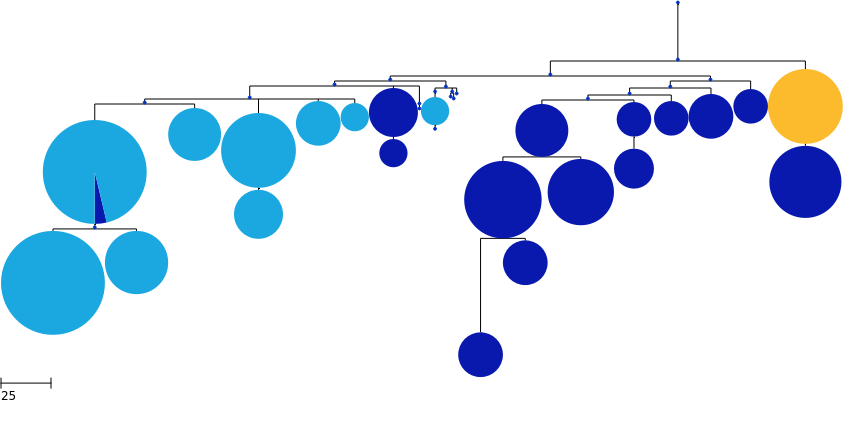

In [ ]:
treeobj = saveTreeobj["m12_all_YFP_IGHV1-18-01_IGHJ3-01_36_2"] 
color_path = "./hex_color.csv"
ts = treeobj.generate_tree_style(color_path = color_path)
treeobj.tree.render("%%inline", tree_style=ts) 

# Main analysis